In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
sales_train_val = pd.read_csv(r'C:\Users\ASUS\Desktop\Academic Work\Academic Research\DEMAND PATTERN\M5 Forecasting\Estimate the unit sales of Walmart retail goods\m5-forecasting-accuracy_unzip files\sales_train_validation.csv')

In [3]:
sales_train_val

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,3,0,1,1,1,3,0,1,1
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,1,2,1,1,1,0,1,1,1
3,HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,0,5,4,1,0,1,3,7,2
4,HOBBIES_1_005_CA_1_validation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,1,1,0,1,1,2,2,2,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30485,FOODS_3_823_WI_3_validation,FOODS_3_823,FOODS_3,FOODS,WI_3,WI,0,0,2,2,...,2,0,0,0,0,0,1,0,0,1
30486,FOODS_3_824_WI_3_validation,FOODS_3_824,FOODS_3,FOODS,WI_3,WI,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
30487,FOODS_3_825_WI_3_validation,FOODS_3_825,FOODS_3,FOODS,WI_3,WI,0,6,0,2,...,2,1,0,2,0,1,0,0,1,0
30488,FOODS_3_826_WI_3_validation,FOODS_3_826,FOODS_3,FOODS,WI_3,WI,0,0,0,0,...,0,0,1,0,0,1,0,3,1,3


# Exclude Test data and get products belonging to "FOODS"

In [4]:
list_cols_drop = ['d_{0}'.format(i) for i in range(1900, 1914)]
sales_train_val = sales_train_val.drop(columns=list_cols_drop)

df_ca_foods = sales_train_val[(sales_train_val['state_id'] == 'CA') & (sales_train_val['cat_id'] == 'FOODS')]
df_ca_category = df_ca_foods.copy()

# Data preprocessing before aggregation

In [5]:
df_ca_category.drop(['item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'], axis = 1, inplace=True)
df_ca_category = pd.melt(df_ca_category, id_vars=['id'])

df_ca_category['Date'] = df_ca_category['variable'].str[2:].astype('int')

dict_date = {}
for i in range(1, 1914):
    dict_date.update({i: (pd.to_datetime('28/01/2011', format='%d/%m/%Y') + pd.to_timedelta(i, unit='D'))})
    
df_ca_category['Date'] = df_ca_category['Date'].map(dict_date)

df_ca_category.set_index('Date', inplace=True)
df_ca_category.drop('variable', axis=1, inplace=True)

In [6]:
df_ca_category_pivoted = pd.pivot_table(df_ca_category, index = 'Date', columns='id')

df_ca_category_pivoted['Day of week'] = df_ca_category_pivoted.index.day_name()

In [7]:
df_ca_category_pivoted[['Day of week']]

,Day of week
id,
Date,
2011-01-29,Saturday
2011-01-30,Sunday
2011-01-31,Monday
2011-02-01,Tuesday
2011-02-02,Wednesday
...,...
2016-04-06,Wednesday
2016-04-07,Thursday


In [8]:
df_ca_category_pivoted = df_ca_category_pivoted.iloc[2:, :]
df_ca_category_pivoted.drop('Day of week', axis = 1, inplace=True)

weekly_data = df_ca_category_pivoted.resample('W').sum()
weekly_data.columns = weekly_data.columns.droplevel()
weekly_data.reset_index(inplace=True)

weekly_data = pd.melt(weekly_data, id_vars = 'Date', value_name = 'value')

# Coefficient of Variance Squared (CV2)

In [43]:
weekly_data_1 = weekly_data[weekly_data['value'] != 0]

In [45]:
cv_data = weekly_data_1.groupby('id').agg(average=('value','mean'), sd=('value','std')).reset_index()
cv_data['cv_sqr'] = (cv_data['sd'] / cv_data['average'])**2

In [46]:
cv_data

,id,average,sd,cv_sqr
0,FOODS_1_001_CA_1_validation,6.115226,3.718823,0.369816
1,FOODS_1_001_CA_2_validation,8.991770,5.443164,0.366448
2,FOODS_1_001_CA_3_validation,9.438017,6.516360,0.476704
3,FOODS_1_001_CA_4_validation,3.247619,1.852354,0.325325
4,FOODS_1_002_CA_1_validation,4.180556,2.529784,0.366184
...,...,...,...,...
5743,FOODS_3_826_CA_4_validation,11.564103,4.164643,0.129698
5744,FOODS_3_827_CA_1_validation,24.982759,9.383620,0.141078
5745,FOODS_3_827_CA_2_validation,13.253521,9.031245,0.464336
5746,FOODS_3_827_CA_3_validation,27.722222,29.537266,1.135232


# Average Demand Interval (ADI) per Product

In [79]:
prod_by_date = weekly_data_1.groupby(['id','Date']).agg(count=('id','count')).reset_index()
skus = prod_by_date.id.value_counts()

In [80]:
from timeit import default_timer as timer
start = timer()

list_adi = list()
for i in range(len(skus.index)):
    a = prod_by_date[prod_by_date['id']==skus.index[i]]
    a['Previous_Date'] = a['Date'].shift(1)
    a['Duration'] = (a['Date'] - a['Previous_Date']).dt.days / 7
    mean_temp = a.Duration.mean()
    list_adi.append([skus.index[i], mean_temp])

end = timer()
print('This line of code took {} minutes'.format((end-start) / 60))

This line of code took 7.554664021666659 minutes


In [81]:
list_adi

[['FOODS_3_741_CA_4_validation', 1.0],
 ['FOODS_2_374_CA_1_validation', 1.0],
 ['FOODS_3_473_CA_2_validation', 1.0],
 ['FOODS_2_244_CA_3_validation', 1.0],
 ['FOODS_3_473_CA_1_validation', 1.0],
 ['FOODS_2_197_CA_3_validation', 1.0],
 ['FOODS_3_668_CA_1_validation', 1.0],
 ['FOODS_3_668_CA_2_validation', 1.0],
 ['FOODS_3_668_CA_3_validation', 1.0],
 ['FOODS_3_668_CA_4_validation', 1.0],
 ['FOODS_3_331_CA_1_validation', 1.0],
 ['FOODS_3_458_CA_3_validation', 1.0],
 ['FOODS_3_228_CA_3_validation', 1.0],
 ['FOODS_3_127_CA_1_validation', 1.0],
 ['FOODS_3_458_CA_4_validation', 1.0],
 ['FOODS_3_127_CA_3_validation', 1.0],
 ['FOODS_3_127_CA_4_validation', 1.0],
 ['FOODS_3_694_CA_1_validation', 1.0],
 ['FOODS_2_013_CA_1_validation', 1.0],
 ['FOODS_3_694_CA_2_validation', 1.0],
 ['FOODS_2_013_CA_3_validation', 1.0],
 ['FOODS_3_694_CA_3_validation', 1.0],
 ['FOODS_3_217_CA_1_validation', 1.0],
 ['FOODS_3_473_CA_3_validation', 1.0],
 ['FOODS_3_217_CA_2_validation', 1.0],
 ['FOODS_3_217_CA_3_valid

In [82]:
ADI_df = pd.DataFrame(list_adi, columns=['id', 'ADI'])

# MERGE CV2 AND ADI DATA

In [83]:
adi_cv = pd.merge(cv_data, ADI_df, on = 'id', how = 'inner')

In [84]:
adi_cv.isnull().sum()

id         0
average    0
sd         0
cv_sqr     0
ADI        0
dtype: int64

In [85]:
adi_cv

,id,average,sd,cv_sqr,ADI
0,FOODS_1_001_CA_1_validation,6.115226,3.718823,0.369816,1.115702
1,FOODS_1_001_CA_2_validation,8.991770,5.443164,0.366448,1.115702
2,FOODS_1_001_CA_3_validation,9.438017,6.516360,0.476704,1.120332
3,FOODS_1_001_CA_4_validation,3.247619,1.852354,0.325325,1.291866
4,FOODS_1_002_CA_1_validation,4.180556,2.529784,0.366184,1.255814
...,...,...,...,...,...
5743,FOODS_3_826_CA_4_validation,11.564103,4.164643,0.129698,1.000000
5744,FOODS_3_827_CA_1_validation,24.982759,9.383620,0.141078,1.017544
5745,FOODS_3_827_CA_2_validation,13.253521,9.031245,0.464336,1.071429
5746,FOODS_3_827_CA_3_validation,27.722222,29.537266,1.135232,1.179775


In [86]:
def category(df):
    a=0

    if((df['ADI']<=1.32) & (df['cv_sqr']<=0.49)):
        a='Smooth'
    if((df['ADI']>=1.32) & (df['cv_sqr']>=0.49)):  
        a='Lumpy'
    if((df['ADI']<1.32) & (df['cv_sqr']>0.49)):
        a='Erratic'
    if((df['ADI']>1.32) & (df['cv_sqr']<0.49)):
        a='Intermittent'
    return a

In [87]:
adi_cv['category']=adi_cv.apply(category,axis=1)

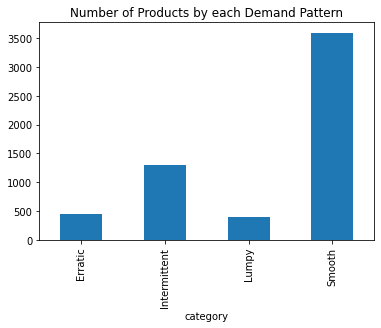

In [88]:
adi_cv.groupby('category')['id'].count().plot(kind='bar')
plt.title('Number of Products by each Demand Pattern')
plt.show()

In [89]:
list_intermittent = adi_cv[adi_cv['category'] == 'Intermittent']['id'].unique().tolist()
list_lumpy = adi_cv[adi_cv['category'] == 'Lumpy']['id'].unique().tolist()
list_smooth = adi_cv[adi_cv['category'] == 'Smooth']['id'].unique().tolist()
list_erratic = adi_cv[adi_cv['category'] == 'Erratic']['id'].unique().tolist()

In [90]:
pd.Series(list_intermittent).to_csv('Intermittent_ID.csv')
pd.Series(list_lumpy).to_csv('Lumpy_ID.csv')
pd.Series(list_smooth).to_csv('Smooth_ID.csv')
pd.Series(list_erratic).to_csv('Erratic_ID.csv')